# Importation des packages

In [1]:
import librosa, librosa.display
import matplotlib.pyplot as plt
import torch as torch
from torch.utils.data import Dataset
import numpy as np
import soundfile as sf
from torchsummary import summary

Ajoutez un raccourci de ce dossier à votre google drive :

https://drive.google.com/drive/folders/1VJk20mb-W_3sYbz3u6qmiFPquP03Dizc?usp=sharing

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Importation des données

Chemin du son sans le bruit.

In [3]:
path_without_noise = "drive/MyDrive/denoising_sound/with_reverb/clean_fileid_44.wav"

Utilisez la fonction `load` de librosa pour importer le son sans bruit.

In [4]:
signal, sr = librosa.load(path_without_noise)

In [6]:
sr

22050

In [5]:
signal.shape

(220500,)

Chemin du son avec le bruit.

In [7]:
path_with_noise = "drive/MyDrive/denoising_sound/with_reverb_and_noise/clnsp17_birds_413745_3_snr2_tl-23_fileid_44.wav"

Utilisez la fonction `load` de librosa pour importer le son sans bruit.

In [8]:
signal_noise, sr_noise = librosa.load(path_with_noise)

In [9]:
signal_noise.shape

(220500,)

Visualisation des données

Utilisez la fonction `waveshow` de librosa pour afficher les deux signales.

Challenge : utilisez matplotlib pour afficher les graphiques cotes à cotes.

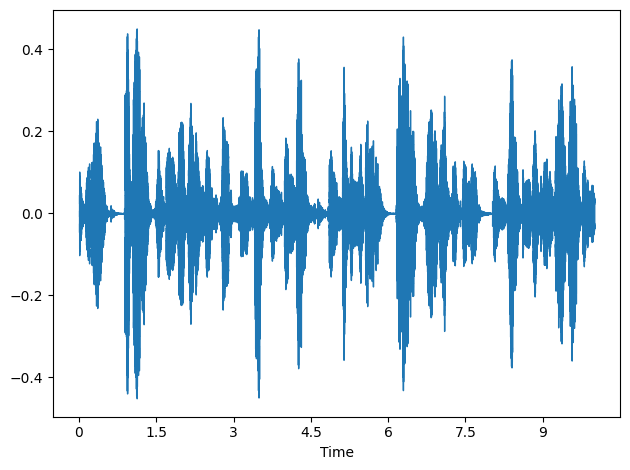

In [12]:
### Your code ###
librosa.display.waveshow(signal)

plt.tight_layout()
plt.show()

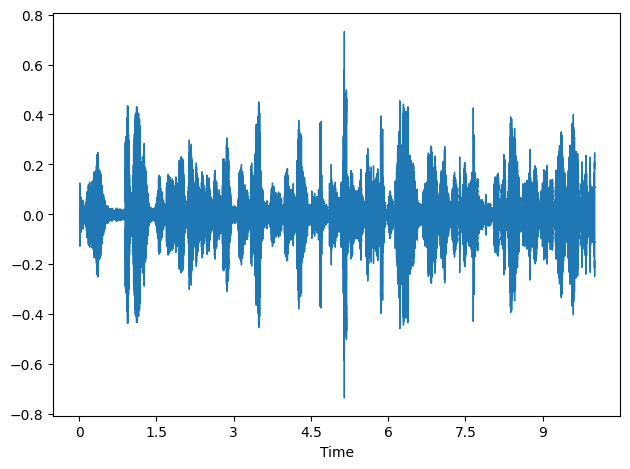

In [13]:
### Your code ###
librosa.display.waveshow(signal_noise)

plt.tight_layout()
plt.show()

# Créer le générateur

La classe permettant de créer notre dataset personnalisé.

In [14]:
class CustomImageDataset(Dataset):
    def __init__(self, x_train, y_train):
        self.img_input = x_train
        self.img_output = y_train

    def __len__(self):
        return len(self.img_output)

    def __getitem__(self, idx):
        image = self.img_input[idx, :, :]
        label = self.img_output[idx, :, :]

        return image, label

Nous allons prendre seulement les 40960 informations de la bande son.

In [15]:
x_training = CustomImageDataset(torch.from_numpy(np.expand_dims(np.expand_dims(signal_noise[:40960], axis=0), axis=1)),
                                 torch.from_numpy(np.expand_dims(np.expand_dims(signal[:40960], axis=0), axis=1)))

Utilisez la fonction `DataLoader` pour créer le générateur.

In [20]:
dataloader_train = torch.utils.data.DataLoader(x_training,
                                         batch_size=1,
                                         shuffle=True)

Vérifiez que les dimensions correspodent bien avec ce qui est attendu.

In [22]:
for x, y in dataloader_train:
  print(x.shape)
  print(y.shape)

  break

torch.Size([1, 1, 40960])
torch.Size([1, 1, 40960])


# Obtenir un sur-entraînement

Vous allez entraîner des modèles pour obtenir un débruitage complet du son bruité.

# fonctions d'entraînement

In [23]:
def step(model:torch.nn.Sequential,
         opt:torch.optim,
         criterion:torch.nn.modules.loss,
         x_train:torch.Tensor,
         y_train:torch.Tensor)->tuple:
  """
  Executes a single training step for a PyTorch model.
  This function performs a forward pass to compute the model's predictions, calculates
  the loss between predictions and actual target values, computes gradients for each
  model parameter, and updates the parameters using the optimizer.

  Args:
      model (torch.nn.Sequential): The PyTorch model to train.
      optimizer (torch.optim.Optimizer): Optimizer used to update the model's parameters.
      criterion (torch.nn.modules.loss._Loss): Loss function used to compute the error.
      x_train (torch.Tensor): Input training data (features).
      y_train (torch.Tensor): Ground truth labels or target values for the training data.
  Returns:
      tuple: The updated model and the computed loss for the current step.
  """

  # Réinitialisez les gradients d'optimizer à zéro avec la méthode 'zero_grad'
  opt.zero_grad()

  # Calculez les prédiction sur le jeu d'entraînement avec la méthode 'froward'
  prediction = model.forward(x_train)

  # Calculez l'erreur de prédiction avec 'criterion'
  loss = criterion(prediction, y_train)

  # Calculez les gradients avec la méthode 'backward'
  loss.backward()

  # Mettre à jour les paramètres du modèle avec la méthode 'step'
  opt.step()

  return model, loss

In [24]:
def fit(model, optimizer, criterion, epoch, trainloader):
    epoch = epoch
    history_train_loss = []

    for e in range(epoch) :

      train_loss_batch = 0

      for images, labels in trainloader:

        # mise à jour des poids avec la fonction 'step'
        model, train_loss = step(model, optimizer, criterion, images, labels)

        train_loss_batch += train_loss.detach().numpy()

      train_loss_batch /= len(trainloader.sampler)

      # Sauvegarde des coûts d'entraînement avec append
      history_train_loss = np.append(history_train_loss, train_loss_batch)

      if e % 100==0:
        print(f'epoch : {e}/{epoch}')
        print('train_loss : '+str(np.squeeze(train_loss_batch)))
        print('-------------------------------------------------------------------------------------------------')

    return model, history_train_loss, history_test_loss

## Première tentative

Initialisez un modèle qui vous serivra de baseline.

Initialiser le modèle suivant:
- Utilisez la fonction `conv_block` pour initialiser une couche de convolution en 1 dimension avec 16 filtres et activer par Relu.
- Une couche de maxpooling avec une fenêtre de 2 et un stride de 2,
- Utilisez la fonction `conv_block` pour initialiser une couche de convolution en 1 dimension avec 32 filtres et activer par Relu.
- Une couche de `ConvTranspose` avec 16 filtres, une taille de filtres de 2 et un stride de 2,
- Une dernière convolution avec un filtre.

Pour ceux modèle vous allez intialisez tous vos composants dans la fonction `__init__` puis les utilisez dans le bonne ordre dans la fonction `forward`.

Vous pouvez vous nspirez de la création du modèle via ce [lien](https://medium.com/analytics-vidhya/unet-implementation-in-pytorch-idiot-developer-da40d955f201)

N'hésitez pas à demander de l'aide à ChatGPT qui permet d'aider à l'élaboration de ce type d'architecture.

In [26]:
from torch import nn
from collections import OrderedDict

In [32]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        # Encodeur (partie descendante)
        self.encoder1 = self.conv_block(1, 16)

        # Couche de réduction de dimension
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        # Couche du bas (bottleneck)
        self.bottleneck = self.conv_block(1,32)

        # Décodeur (partie montante)
        self.upconv2 = nn.ConvTranspose1d(in_channels=32, out_channels=16, kernel_size=2, stride=2)


        self.final_layer = nn.Conv1d(16,1,3)


    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding="same"),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Encodeur
        enc1 = self.encoder1(x)
        pool1 = self.pool(enc1)

        # Bottleneck
        bottleneck = self.bottleneck(pool1)

        # Décodeur avec les skip connections
        dec2 = self.upconv2(bottleneck)
        cat2 = self.final_layer(dec2)

        # Couche final
        output = self.final_layer(cat2)

        return output

Utilisez la fonction `UNet` pour initialiser le modèle.

In [33]:
model = UNet()

Utilisez la fonction `summary` pour visualisez votre modèle.

A noter : Vous ne verrez pas apparaitre vos concatenations dans le summary c'est normal.

In [35]:
summary(model,(1, 1, 40960))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

Utilisez le modèle avec la méthode `forward`.

In [ ]:
test = torch.randn(1, 1, 128)
result = None
result.shape

Initialisez `criterion` avec la fonction `L1Loss`.

Initialisez `optimizer` avec `Adam` et un learning rate de 0.001.

In [ ]:
criterion = None
optimizer = None

In [ ]:
epoch = 3000

Utilisez la fonction `fit` pour entraîner le modèle.

In [ ]:
model, history_train_loss, history_test_loss = None

Utilisez la méthode `forward` pour prédire le résultat du modèle à partir de `signal_noise_expand`

In [ ]:
signal_pred = None

Utilisez la fonction `write` du package `soundfile` pour enregistrer `signal_noise_expand`, `signal_exapnd` et `signal_pred` avec pour nom respectif `reel_1.wav`, `pred_1.wav` et `noise_1.wav`.

In [ ]:
sf.write(None)
sf.write(None)
sf.write(None)

Ecoutez le résultat afin de voir s'il est satisfaiant.

## Modèle finale

Maintenant que vous avez construit votre baseline L'objectif de ce TP est de complexifier le modèle jusqu'à ce qu'il soit capable de débruiter parfaitement le son bruité.